# Wasserstein GAN

For a summary of changes introduced by Wasserstein GANs, see the original paper or https://www.alexirpan.com/2017/02/22/wasserstein-gan.html:

- Discriminator gives continuous output
- Loss is the difference in mean output (Critic) and mean output on generated data for optimal critic (generator)
- Apply gradient regularization to ensure the assumption that the critic is a K-Lipschitz function

Thanks to the pytorch implementation in https://github.com/caogang/wgan-gp/blob/master/gan_toy.py

In [1]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision

In [0]:
import numpy as np

In [0]:
import torch
from torch import nn, optim
# Variable provides a wrapper around tensors to allow automatic differentiation, etc.
from torch.autograd.variable import Variable 
from torchvision import transforms, datasets
import torch.autograd as autograd

import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [0]:
def load_mnist_data():
    compose = transforms.Compose([ # 'compose' several transforms together
        transforms.ToTensor(),
        transforms.Normalize((.5,.5,.5),(.5,.5,.5)) # normalize by mean and std per channel
        #TODO: This seems less than ideal, because values more extreme than -1/1 are possible?
    ])
    out_dir='./dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True) # download and transform data

In [0]:
data = load_mnist_data()

In [0]:
n_batches = 64
data_loader = torch.utils.data.DataLoader(data, batch_size=n_batches, shuffle=True)

In [0]:
def images_to_vectors(images):
    # TODO: What module is the view from?
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

In [0]:
def make_noise(size):
    """
    Generates a vector with length 100 of Gaussian noise with (batch_size, 100)
    """
    n = Variable(
        torch.randn(size) # random values from standard normal
    )  
    return n

def make_labels(N, labels):
    """
    Generate a N batch of labels from equally probable nominal (minimum, maximum)
    """
    l = Variable(torch.randint(size=[N,1], low=labels[0], high=labels[1]+1))
    return l
    

In [0]:
class GeneratorNet(torch.nn.Module):
    """
    A three-layer generative neural network
    """
    def __init__(self):
        super().__init__()
        n_features = 100 + 1
        # TODO: Why 100 random input numbers? 
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
            # TODO: Why no dropout in generator?
        )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
        


In [0]:
class CriticNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super().__init__() # get the __init__() from the parent module
        n_features = 784 + 1
        n_out = 1
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 1024), # Linear transformation part input*W+b
            nn.LeakyReLU(0.2), # leaky relu is more robust for GANs than ReLU
            nn.Dropout(0.3)
            )
        
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512), # Linear transformation part input*W+b
            nn.LeakyReLU(0.2), # leaky relu is more robust for GANs than ReLU
            nn.Dropout(0.3)
            )
            
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256), # Linear transformation part input*W+b
            nn.LeakyReLU(0.2), # leaky relu is more robust for GANs than ReLU
            nn.Dropout(0.3)
        )
        
        self.out = nn.Sequential(
            nn.Linear(256, n_out), # Linear transformation part input*W+b
        )
    
    # Careful to make forward() a function of the net, not of __init__
    def forward(self, x):
        # TODO: There must be a more concise way to build the network from the layers
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
        

            

In [0]:
def critic_loss(output_real, output_fake):
    """
    Wasserstein distance to minimize as loss for the critic
    """
    return -(torch.mean(output_real) - torch.mean(output_fake))

def generator_loss(output_fake):
    """
    Loss to minimize for the generator on the output of the optimal critic
    """
    return -torch.mean(output_fake)

def interpolate_data(real_data, fake_data):
    eps = torch.rand(real_data.size(0), 1) # A random unif number for each obs in the batch
    eps = eps.expand(real_data.size()).to(device) # Can only multiply tensors with tensors, so expand to same dimensions
    interpolated_data = eps*real_data + (1-eps)*fake_data
    interpolated_data = Variable(interpolated_data, requires_grad=True) # Transform into Variable again
    return interpolated_data

def calc_gradient_penalty(critic, real_data, fake_data):
    interpolated_data = interpolate_data(real_data, fake_data)
    critic_output = critic(interpolated_data)
    gradients = autograd.grad(inputs=interpolated_data, outputs=critic_output,
                             grad_outputs=torch.ones(critic_output.size()).to(device),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty=((gradients.norm(2, dim=1)-1) ** 2).mean()
    return gradient_penalty

In [0]:
def train_critic(optimizer, real_data, fake_data):
    N = real_data.size(0) # Get number of rows from torch tensor
    optimizer.zero_grad() # reset gradient
    
    # Note: Calling backward() multiple times will acumulate the gradients
    # until they are reset with zero_grad()
    # real data loss + gradient
    output_real = critic.forward(real_data)
    
    # train on fake data
    output_fake = critic.forward(fake_data)
    loss = critic_loss(output_real, output_fake)

    
    # Gradient penalty
    gradient_penalty = calc_gradient_penalty(critic, real_data,fake_data)
      
    # Weight update
    loss = loss + 10*gradient_penalty
    loss.backward()
    optimizer.step()
    
    # Return error and predictions for monitoring
    return loss, output_real, output_fake

In [0]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0) # Get number of rows from torch tensor
    optimizer.zero_grad() # reset gradient
    
    # Get discriminator prediction output
    critic_prediction = critic.forward(fake_data)
    
    # See explanation above. Intuitively, we create loss if the 
    # discriminator predicts our pseudo-ones as zeros.
    loss_generator = generator_loss(critic_prediction)
    loss_generator.backward()
    
    # Weight update
    optimizer.step()
    
    # Return error and predictions for monitoring
    return loss_generator

### Training

In [0]:
generator = GeneratorNet().to(device)
critic = CriticNet().to(device)

In [0]:
validation_noise = torch.cat([make_noise([1,100]),make_labels(1,labels=[0,9])], dim=1).to(device)

In [17]:
validation_noise[0][-1]

tensor(4., device='cuda:0')

In [0]:
critic_performance = []
generator_performance = []

In [0]:
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-4)
generator_optimizer = optim.Adam(generator.parameters(), lr=1e-4)

In [20]:
num_epochs = 20

for epoch in range(num_epochs):
    # enumerate() outputs index, value for an indexable object
    # output the index of the batch and the output of data_loader
    # data_loader() outputs a batch of images and their label (which we don't need in this case)
    for n_batch, (real_batch,real_label) in enumerate(data_loader):
        N = real_batch.size(0) # Get the number of images from tensor
        
        ## Train discriminator
        # Collect real data
        real_label = real_label.reshape([N,1]).float().to(device) # Turn int to float
        real_batch = real_batch.to(device)
        real_data = Variable(torch.cat([images_to_vectors(real_batch),real_label], dim=1))
        
        temp_performance = []
        for k in range(5):
            # Create fake data
            fake_labels = make_labels(N, labels=[0,9]).to(device)
            fake_noise = make_noise([N,100]).to(device)
            noise_input = torch.cat([fake_noise, fake_labels], dim=1)
            fake_data = generator(noise_input).detach()
            # generator() creates a graph on the fly, which we drop after collecting the fake data
            fake_data = torch.cat([fake_data, fake_labels], dim=1)
            disc_error, disc_pred_real, disc_pred_fake = train_critic(critic_optimizer, real_data, fake_data)
            temp_performance.append(disc_error.detach().cpu().numpy())
        critic_performance.append(np.mean(temp_performance))
        
        ## Train generator
        fake_labels = make_labels(N, labels=[0,9]).to(device)
        fake_noise = make_noise([N,100]).to(device)
        noise_input = torch.cat([fake_noise, fake_labels], dim=1)
        fake_data = generator(noise_input)
        # This time we keep the graph, because we to backprop on it in the training function
        gen_error = train_generator(generator_optimizer, 
                                    torch.cat([fake_data, fake_labels], dim=1))
        
        generator_performance.append(gen_error.detach().cpu().numpy())
        
        if n_batch % 20 ==0:
            test_images = vectors_to_images(generator(validation_noise))
            test_images = test_images.data # Get values from pytorch tensor
            
            plt.imshow(test_images.reshape(28,28), cmap='gray')
            plt.show()
        

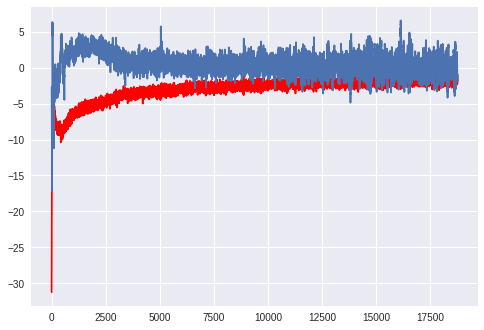

In [21]:
import matplotlib.pyplot as plt
plt.plot(critic_performance[10:], color = "red")
plt.plot(generator_performance[10:])
plt.show()

In [0]:
examples_noise = torch.cat([make_noise([10,100]).to(device),
                            torch.Tensor(np.arange(0,10).reshape(10,1)).to(device)], dim=1)
example_fake = vectors_to_images(generator(examples_noise)).data

In [23]:
example_fake.shape

torch.Size([10, 1, 28, 28])

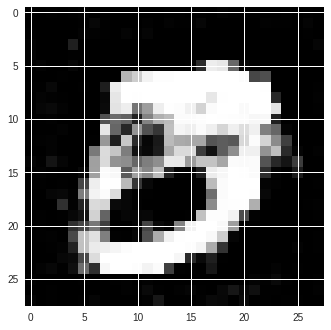

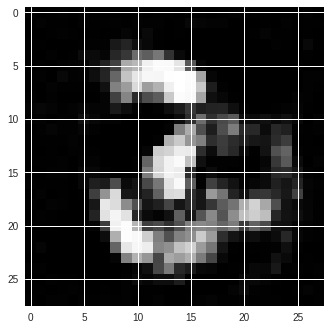

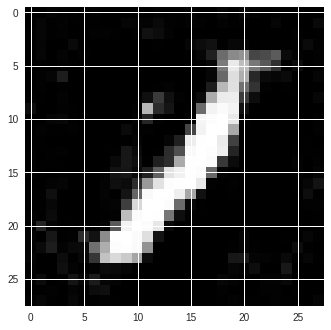

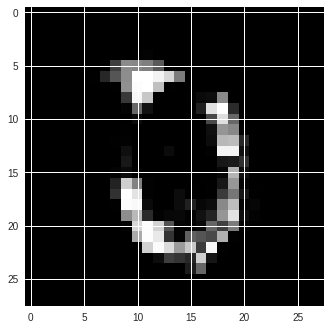

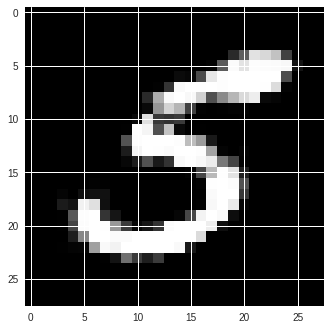

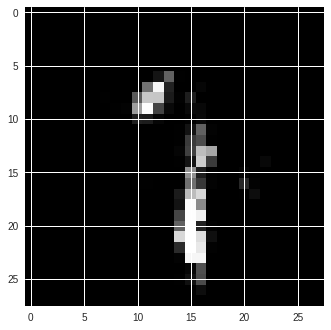

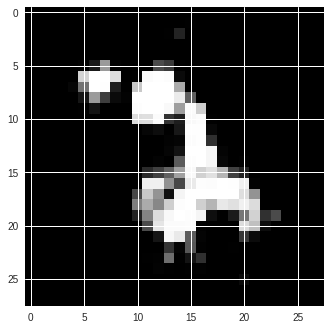

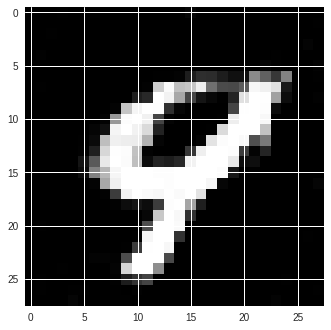

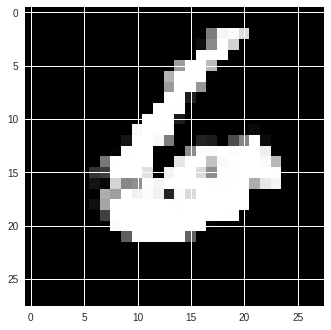

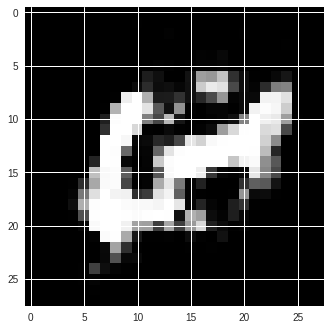

In [24]:
for i in range(example_fake.shape[0]):
    plt.imshow(example_fake[i,:,:,:].reshape(28,28), cmap='gray')
    plt.show()

In [0]:
# Real tabular data

In [0]:
https://archive.ics.uci.edu/ml/machine-learning-databases/census1990-mld/USCensus1990.data.txt